In [1]:
import sys
sys.path.append('../src')

import os
import torch
import glob
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

from ocr_data_loader import *
from ocr_utils import *
from ocr_image_transformations import *
from ocr_model import OCRModel
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
import torchvision
from PIL import Image
import torch
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import random
import time

from ocr_utils import *
from torch import nn

In [2]:
BASE_DIR = '../../GT4HistOCR/corpus'
DATA_SET_NAME = 'RefCorpus-ENHG-Incunabula'
HOLDOUT_BOOK = '1499-CronicaCoellen'
MODEL_NAME = '17/model_3a20e32bea03553c26a0989a9ff9892d7dcd5918_dict'
FRAME_SIZE = 1
HIDDEN_LAYER_SIZE = 200
HIDDEN_LAYERS_NUM = 3
ALPHABET_SIZE = 92
BATCH_SIZE = 10

MAX_IMAGE_WIDTH=500
MAX_IMAGE_HEIGHT=20

INPUT_DIMENSION = MAX_IMAGE_HEIGHT * FRAME_SIZE

transformation = transforms.Compose([
    ImageThumbnail(MAX_IMAGE_HEIGHT, MAX_IMAGE_WIDTH),
    transforms.ToTensor(),
    ImageTensorPadding(MAX_IMAGE_HEIGHT, MAX_IMAGE_WIDTH),
    UnfoldImage(1, FRAME_SIZE)
])

train_data, test_data, holdout_data , dataset = load_data(base_dir = BASE_DIR, dataset_name = DATA_SET_NAME, 
                                           holdout_book = HOLDOUT_BOOK, transformation=transformation,
                                           batch_size=BATCH_SIZE, train_test_split=.8)

model = OCRModel(INPUT_DIMENSION, HIDDEN_LAYER_SIZE, HIDDEN_LAYERS_NUM, ALPHABET_SIZE)

state_dict = torch.load(f'../../models/RefCorpus-ENHG-Incunabula/{MODEL_NAME}.pth',
                       map_location=torch.device('cpu'))


model.load_state_dict(state_dict)
model.eval()

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#losses = model.train_model(holdout_data, optimizer, 1, 1000)

1628
23158


OCRModel(
  (lstm): LSTM(20, 200, num_layers=3, batch_first=True, bidirectional=True)
  (drop_out): Dropout(p=0.0, inplace=False)
  (fc): Linear(in_features=400, out_features=92, bias=True)
)

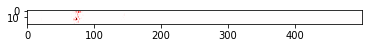

In [3]:
for batch in enumerate(holdout_data):
    text_vector_batch = batch[1]['text_vector']
    text_length_batch = batch[1]['text_length']
    x = batch[1]['image']
    x.requires_grad_()
    
    probabilities = model(x).permute(1,0,2)
    
    ctc_loss = nn.CTCLoss(zero_infinity=True)
    
    probabilities_lengths = torch.full((probabilities.shape[1],), 
                                                   probabilities.shape[0], dtype=torch.long)
    output = text_vector_batch
    output_lengths = text_length_batch
    
    loss = ctc_loss(probabilities, output, probabilities_lengths, output_lengths)
    
    loss.backward()
    transforms.ToPILImage()(x[0].T).show()
                
    explanation = (x.grad[0].T**2).data
    plt.imshow(explanation, cmap='seismic', vmin=-abs(explanation).max(), vmax=abs(explanation).max())
    break

In [3]:
# Get the full dataset just to extract alphabet
print( "============== Infer evaluation data")
predictions = model.predict(holdout_data, dataset.alphabet)
print_predicted_text(predictions, dataset.alphabet, samples_number = 10000)
error = get_prediction_error(predictions)

print(f'Prediction error {error}')


============== Infer evaluation data
Original Text:   ſpricht dat mach waill ſyn dat die lude zo der zijt. want ſy alſo lange zijt leueden. hauen
Predicted Text:  ſyricht dat mach waill ſyn dat dielude zo der zijt.want ſy alſolange zijt lrueden. hauen Confidence: 0.9641852827184607
ſ: 0.99 y: 0.88 r: 1.00 i: 1.00 c: 1.00 h: 0.97 t: 1.00  : 1.00 d: 0.96 a: 1.00 t: 0.96  : 1.00 m: 1.00 a: 0.93 c: 0.93 h: 1.00  : 1.00 w: 1.00 a: 1.00 i: 0.97 l: 0.99 l: 1.00  : 0.95 ſ: 1.00 y: 1.00 n: 0.99  : 1.00 d: 1.00 a: 1.00 t: 1.00  : 0.94 d: 0.89 i: 1.00 e: 1.00 l: 1.00 u: 0.95 d: 0.82 e: 0.92  : 1.00 z: 0.99 o: 1.00  : 0.86 d: 0.99 e: 0.98 r: 1.00  : 0.92 z: 1.00 i: 1.00 j: 0.83 t: 1.00 .: 0.68 w: 0.94 a: 1.00 n: 0.97 t: 1.00  : 0.99 ſ: 1.00 y: 1.00  : 0.94 a: 1.00 l: 1.00 ſ: 1.00 o: 1.00 l: 1.00 a: 0.83 n: 0.88 g: 1.00 e: 1.00  : 1.00 z: 1.00 i: 1.00 j: 0.83 t: 1.00  : 0.97 l: 0.92 r: 0.85 u: 1.00 e: 0.95 d: 1.00 e: 1.00 n: 0.99 .: 0.84  : 0.95 h: 0.96 a: 0.92 u: 0.92 e: 0.98 n: 0.98  

Original T


Original Text:   zaill wegen der dage. als etzliche ſagen / ſunder dairumb Want vp die zijt des begintz
Predicted Text:  zaill wegen der dage. als etzliche ſagen / ſuider dairumb Want vp die zijt des begint Confidence: 0.9779193377190647
z: 1.00 a: 1.00 i: 1.00 l: 0.98 l: 0.96  : 0.99 w: 1.00 e: 1.00 g: 0.98 e: 1.00 n: 1.00  : 1.00 d: 0.99 e: 0.92 r: 1.00  : 1.00 d: 1.00 a: 1.00 g: 1.00 e: 1.00 .: 0.96  : 0.96 a: 1.00 l: 1.00 s: 1.00  : 1.00 e: 0.94 t: 1.00 z: 0.93 l: 1.00 i: 1.00 c: 1.00 h: 1.00 e: 1.00  : 0.92 ſ: 1.00 a: 0.95 g: 1.00 e: 1.00 n: 1.00  : 0.92 /: 0.98  : 1.00 ſ: 0.98 u: 0.98 i: 0.93 d: 1.00 e: 1.00 r: 1.00  : 0.98 d: 0.93 a: 1.00 i: 1.00 r: 1.00 u: 1.00 m: 1.00 b: 0.56  : 0.98 W: 0.90 a: 1.00 n: 1.00 t: 1.00  : 0.99 v: 0.99 p: 1.00  : 1.00 d: 1.00 i: 1.00 e: 1.00  : 0.96 z: 0.98 i: 1.00 j: 0.94 t: 0.93  : 0.99 d: 0.95 e: 1.00 s: 1.00  : 0.96 b: 1.00 e: 1.00 g: 0.95 i: 1.00 n: 0.98 t: 0.92  

Original Text:   albus off. xxvj. albus rader gelt. ð
Predicted Text:  alhus o

n: 1.00 e: 1.00 m: 1.00 e: 0.99 l: 1.00 i: 0.93 c: 0.92 h: 1.00  : 1.00 t: 1.00 z: 0.99 o: 1.00  : 0.99 L: 0.53 u: 0.99 b: 0.97 e: 0.98 c: 1.00 k: 1.00  : 0.91 e: 1.00 y: 1.00 n: 1.00 e: 0.99  : 0.93 k: 0.94 y: 1.00 ſ: 0.85 t: 0.88 e: 1.00  : 0.93 J: 0.91 t: 1.00 e: 0.99 m: 1.00  : 0.96 t: 0.95 z: 1.00 o: 1.00  : 0.96 B: 0.77 r: 0.76 u: 1.00 n: 1.00 ß: 1.00  : 0.94 w: 1.00 i: 1.00 c: 1.00 h: 1.00  : 1.00 e: 1.00 y: 1.00 n: 0.96 e: 0.99  : 0.99 k: 1.00 y: 1.00 ſ: 1.00 t: 0.97 e: 0.94 .: 0.90  : 0.97 J: 0.98 t: 0.92 e: 0.98 m: 1.00  : 1.00 t: 0.91 z: 0.95 o: 1.00  : 1.00 C: 0.99  : 0.88 o: 1.00 e: 0.99 l: 1.00 l: 1.00 e: 0.95 n: 1.00  : 1.00 e: 1.00 y: 0.99 n: 1.00 d: 0.75  

Original Text:   heyt vnd is vã. xxiiij. bis an die. xxx. jair. Dat vunffte alder is genoempt dye man /
Predicted Text:  heyt vnd is vã · xxüũ. bis an die xx · ſair. Dat vunffte alder is genoempt dye man⸗ Confidence: 0.9670928921741405
h: 0.99 e: 0.99 y: 1.00 t: 0.96  : 1.00 v: 1.00 n: 1.00 d: 1.00  : 0.94 i: 1.00 s